# Hough Transform Testing

In [5252]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import ndimage as nd
import random

In [5253]:
# Find all normal lines from point pairs
def points2lines(points):
    lines = np.zeros([1,3])
    r,c = points.shape
    while(r>1):
        for i in np.arange(1,r):
            line = np.cross(points[0,:], points[i,:])
            lines = np.vstack([lines, line])
        points = points[1:,:]
        r,c = points.shape
    lines = lines[1:,:]
 
    return lines

# Convert linear eqn to rho-theta
def plane2hough(lines):

    slope = -lines[0]/lines[1]
    theta = math.atan(-1/slope)
    if theta !=(0):
        b = -lines[2]/lines[1]
        x = -b/(slope+1/slope)
        y = slope*x + b
        rho = x*np.cos(theta) + y*np.sin(theta)
    else:
        rho = -lines[2]/lines[0]
    rhotheta = [rho, theta]

    return rhotheta

def gradientMag(image):
    sobelx = np.array([[1,0,-1],
                    [2,0,-2],
                    [1,0,-1]])

    sobely = np.array([[ 1, 2, 1],
                    [ 0, 0, 0],
                    [-1,-2,-1]])

    Ix = nd.convolve(image,sobelx)
    Iy = nd.convolve(image,sobely)
    mag = np.sqrt(Ix**2+Iy**2)
    return mag

Create a test image of a square

In [5254]:
def diagImage(size,sigma,threshold):

    # Create image with lines
    r = 25
    c = r
    image = np.zeros([size,size])
    line = 255*np.eye(size)
    image = np.fliplr(image+line)
    image = image+line

    # Add noise to the image
    mean = 0
    noise = sigma*np.random.randn(size,size) + mean
    image = image+noise

    # Find edges from the gradient
    image = gradientMag(image)

    # Submax supression
    mask = 1*( image >= threshold*np.amax(image))
    return mask

# RANSAC
"The input to the RANSAC algorithm is a set of observed data values, a way of fitting some kind of model to the observations, and some confidence parameters. RANSAC achieves its goal by repeating the following steps:

1. Select a random subset of the original data. Call this subset the hypothetical inliers.
2. A model is fitted to the set of hypothetical inliers.
3. All other data are then tested against the fitted model. Those points that fit the estimated model well, according to some model-specific loss function, are considered as part of the consensus set.
4. The estimated model is reasonably good if sufficiently many points have been classified as part of the consensus set.
5. Afterwards, the model may be improved by reestimating it using all members of the consensus set.

This procedure is repeated a fixed number of times, each time producing either a model which is rejected because too few points are part of the consensus set, or a refined model together with a corresponding consensus set size. In the latter case, we keep the refined model if its consensus set is larger than the previously saved model."

https://en.wikipedia.org/wiki/Random_sample_consensus

In [5255]:
def RANSAC(data,e,model,threshold):
    # probability that one sample is clean
    p = 0.99
    # probablility that point is an outlier
    e = 0.95
    # number of samples needed
    N = np.log(1-p) / np.log(1-(1-e)**model)
    N = np.int(np.round(N))

    # [num of inliers, rho, theta, (x1,y1), (x2,y2)]
    votes = np.zeros(9)
    bestFit = 0

    # Add a column of 1's to the end
    r,c = data.shape
    data = np.hstack([data, np.ones([r,1])])

    i = 0
    while i < N:
        # Find two random edgels
        pair = np.random.randint(data.shape[0],size=2)

        # Insure pairs are unique
        while pair[0] == pair[1]:
            pair[1] = np.random.randint(data.shape[0])
        pair = data[pair]

        # Convert edgels to (a,b,c)
        plane = points2lines(pair)
        plane = np.concatenate(plane)

        # Edgel distance to plane
        plane_norm = np.sqrt(np.sum(plane[0:2]**2))
        dist = np.abs(np.dot(data,plane.T)) / plane_norm

        # Threshold distances
        inliers = data[dist <= threshold]
        num_inlier = np.sum(inliers[:,2])

        if num_inlier > votes[0]:
            votes = np.hstack([num_inlier, np.reshape(pair,6)])

        i += 1
    
    # Refit with inliers
    pair = np.reshape(votes[1:],(2,3))

    # Convert edgels to (a,b,c)
    plane = points2lines(pair)
    plane = np.concatenate(plane)
    
    # Edgel distance to plane
    plane_norm = np.sqrt(np.sum(plane[0:2]**2))
    dist = np.abs(np.dot(data,plane.T)) / plane_norm
    
    inliers = data[dist <= threshold]
    inliers = inliers.astype(int)

    return inliers[:,0:2]


0.9965725253633123

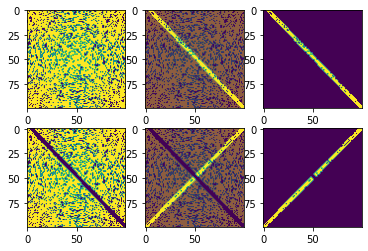

In [5256]:
# Create noisy image with line
size = 100
sigma = 50
threshold = 0.1
mask = diagImage(size,sigma,threshold)
edgels = np.where(mask==1)
edgels = np.array(edgels).T

# Execute RANSAC
e = 0.75
model = 2
threshold = 2
inliers = RANSAC(edgels,e,model,threshold)


###################################################
# Plot the results
plt.subplot(2,3,1)
plt.imshow(mask)

plt.subplot(2,3,2)
good = np.zeros([mask.shape[0], mask.shape[0]])
good[inliers[:,0], inliers[:,1]] = 1
plt.imshow(mask)
plt.imshow(good, alpha = 0.6)

plt.subplot(2,3,3)
plt.imshow(good)


####################################################
# Remove line from plot
mask[inliers[:,0], inliers[:,1]] = 0
edgels = np.where(mask==1)
edgels = np.array(edgels).T

# Repeat RANSAC
inliers = RANSAC(edgels,e,model,threshold)

plt.subplot(2,3,4)
plt.imshow(mask)

plt.subplot(2,3,5)
good = np.zeros([mask.shape[0], mask.shape[0]])
good[inliers[:,0], inliers[:,1]] = 1
plt.imshow(mask)
plt.imshow(good, alpha = 0.6)

plt.subplot(2,3,6)
plt.imshow(good)

1-25/(np.sum(mask)-25)